# High-Ram Validation

In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.

# Lectura CSV

In [ ]:
import pandas as pd
df_spy = pd.read_csv('spy_options_call_output_all.csv')

In [ ]:
# Ordenar cronológicamente el dataset
df_spy = df_spy.sort_values(by=['quote_date', 'expire_date'], ascending=True).reset_index(drop=True)

In [ ]:
# Verificar si esta ordenado correctamente
print(df_spy['quote_date'].head())
print(df_spy['quote_date'].tail())

0    2020-01-02
1    2020-01-02
2    2020-01-02
3    2020-01-02
4    2020-01-02
Name: quote_date, dtype: object
154836    2023-12-29
154837    2023-12-29
154838    2023-12-29
154839    2023-12-29
154840    2023-12-29
Name: quote_date, dtype: object


In [ ]:
df_spy.head()

,quote_date,expire_date,dte,underlying_last,strike,strike_distance,strike_distance_pct,c_last,c_bid,c_ask,...,relative_spread,dte_year,c_volume_log,c_volume_log_scaled,volume_zero,moneyness,iv_pct_rank,c_iv_min,iv_skew,spread_mid_price
0,2020-01-02,2020-01-03,1.0,324.87,331.5,6.6,0.020,0.05,0.0,0.02,...,2.0,0.003968,2.708050,0.396255,0,0.980000,0.615385,0.07086,0.03798,2.0
1,2020-01-02,2020-01-03,1.0,324.87,332.0,7.1,0.022,0.01,0.0,0.02,...,2.0,0.003968,1.945910,0.284735,0,0.978524,0.628205,0.07086,0.04462,2.0
2,2020-01-02,2020-01-03,1.0,324.87,332.5,7.6,0.023,0.02,0.0,0.02,...,2.0,0.003968,3.688879,0.539775,0,0.977053,0.692308,0.07086,0.05172,2.0
3,2020-01-02,2020-01-03,1.0,324.87,336.0,11.1,0.034,0.03,0.0,0.02,...,2.0,0.003968,4.304065,0.629792,0,0.966875,0.846154,0.07086,0.10017,2.0
4,2020-01-02,2020-01-03,1.0,324.87,340.0,15.1,0.047,0.01,0.0,0.02,...,2.0,0.003968,0.693147,0.101425,0,0.955500,0.910256,0.07086,0.15350,2.0


In [ ]:
df_spy.shape

(154841, 31)

# Features

In [ ]:
df_spy.groupby('anio').size()

,0
anio,
2020,31605
2021,40002
2022,40174
2023,43060


In [ ]:
# Test data
df_spy_2023 = df_spy[df_spy['anio'] == 2023]

In [ ]:
# Train data
df_spy = df_spy[df_spy['anio'] < 2023]

In [ ]:
# target_train = 'c_mid_price'
# target_test = 'c_last'
# MAE: 0.6235434835084429
# RMSE: 2.648048019022547
# R²: 0.9926071365933151

features_cols = [
                 # Variables Black Scholes (captura el comportamiento teorico del precio de la opcion)
                 'moneyness', # contiene a 'underlying_last' y 'strike'
                 'dte_year',
                 'c_iv',
                  # Variables que capturan micro-comportamientos del precio real de la opcion (utilizando 'c_mid_price' en periodo de entrenamiento)
                 'iv_skew',
                 'iv_pct_rank',
                 'c_volume_log_scaled', # volumen y liquidez
                 # Indicadores Greeks (aportan estructura del modelo BS)
                 'c_delta',
                 'c_gamma',
                 'c_vega',
                 'c_theta'
                  ]

Manten tu esquema:
- target_train = c_mid_price (mas estable al momento de entrenar)
- target_test = c_last (testear con valores reales del mercado)

Ese esquema es excelente y es exactamente lo que usan:
- market makers
- modelos basados en BS/Heston
- desk de volatilidad

In [ ]:
# target_train = 'c_last' # Para predecir el precio real transado de una opcion (Hacer un modelo robusto a mercado real, existe mucho mas ruido del mercado)
target_train = 'c_mid_price' # Para predecir (modelar) el precio teorico justo o replicar Black-Scholes
target_test = 'c_last'

In [ ]:
X = df_spy[features_cols]
y = df_spy[target_train]

In [ ]:
X_test_2023 = df_spy_2023[features_cols]
y_test_2023 = df_spy_2023[target_test]

In [ ]:
X.dtypes

,0
moneyness,float64
dte_year,float64
c_iv,float64
iv_skew,float64
iv_pct_rank,float64
c_volume_log_scaled,float64
c_delta,float64
c_gamma,float64
c_vega,float64
c_theta,float64


In [ ]:
X.describe()

,moneyness,dte_year,c_iv,iv_skew,iv_pct_rank,c_volume_log_scaled,c_delta,c_gamma,c_vega,c_theta
count,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000,111781.000000
mean,1.043651,0.014947,0.458283,0.272342,0.414681,0.455260,0.586587,0.018097,0.059625,-0.156489
std,0.131570,0.009988,0.471658,0.474468,0.279375,0.265914,0.408220,0.040045,0.060674,0.169203
min,0.564118,0.000000,0.011770,-1.086930,0.001412,0.000000,0.000110,0.000000,0.000000,-0.999930
25%,0.975635,0.007937,0.186720,0.016160,0.171053,0.214680,0.057780,0.001830,0.012920,-0.222150
50%,1.020546,0.015873,0.281970,0.121470,0.366412,0.442098,0.817250,0.007230,0.037270,-0.100660
75%,1.076613,0.023810,0.517200,0.327620,0.639731,0.673646,0.947600,0.023350,0.087920,-0.028200
max,3.812400,0.031905,2.999450,2.961430,1.000000,1.000000,1.000000,1.603600,0.296900,-0.001620


In [ ]:
print(df_spy['moneyness_category'].value_counts())
print(df_spy['moneyness_category'].value_counts(normalize=True)*100)

moneyness_category
ITM    69226
OTM    42544
ATM       11
Name: count, dtype: int64
moneyness_category
ITM    61.930024
OTM    38.060135
ATM     0.009841
Name: proportion, dtype: float64


In [ ]:
y.describe()

,c_mid_price
count,111781.000000
mean,19.708126
std,28.658286
min,0.010000
25%,0.175000
50%,8.940000
75%,27.050000
max,281.265000


In [ ]:
print("cantidad features:", X.shape[1])
print("cantidad target:", len(y.shape))

cantidad features: 10
cantidad target: 1


In [ ]:
X.dtypes

,0
moneyness,float64
dte_year,float64
c_iv,float64
iv_skew,float64
iv_pct_rank,float64
c_volume_log_scaled,float64
c_delta,float64
c_gamma,float64
c_vega,float64
c_theta,float64


# Multi-Layer Perceptron (MLP)

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Split

In [ ]:
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X
y_train = y

# transformamos el target con log1p
y_train_log = np.log1p(y_train)

In [ ]:
y.describe()

,c_mid_price
count,111781.000000
mean,19.708126
std,28.658286
min,0.010000
25%,0.175000
50%,8.940000
75%,27.050000
max,281.265000


In [ ]:
y_train_log.describe()

,c_mid_price
count,111781.000000
mean,2.026097
std,1.561906
min,0.009950
25%,0.161268
50%,2.296567
75%,3.333989
max,5.642846


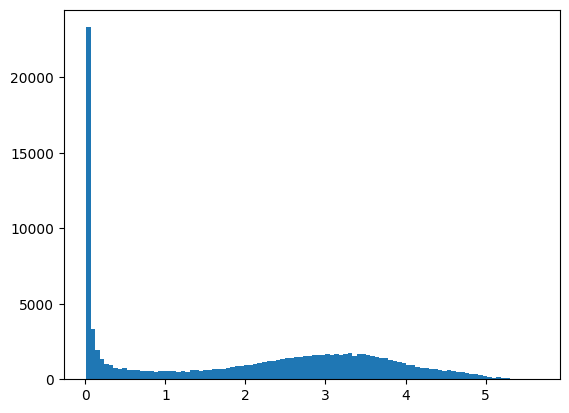

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train_log, bins=100);

In [ ]:
print(f"Cantidad Registros para X_train: {X_train.shape[0]}")

Cantidad Registros para X_train: 111781


In [ ]:
print(f"Cantidad Registros para X_test_2023: {X_test_2023.shape[0]}")

Cantidad Registros para X_test_2023: 43060


## Escalar features

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled  = scaler.transform(X_test)

X_test_2023_scaled = scaler.transform(X_test_2023)

## Construir modelo

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.activations import swish
import tensorflow as tf

In [ ]:
best_model = Sequential([
    Dense(256, activation=swish, input_shape=(X_train.shape[1],)),
    Dropout(0.15),

    Dense(128, activation=swish),
    BatchNormalization(),
    Dropout(0.10),

    Dense(64, activation=swish),

    Dense(32, activation=swish),

    Dense(1)  # precio
])

optimizer = AdamW(learning_rate=3e-4, weight_decay=1e-5)

best_model.compile(optimizer=optimizer, loss='mse', metrics=[
        tf.keras.metrics.R2Score(name='r2')
    ])

best_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,593 (182.00 KB)

 Trainable params: 46,337 (181.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.2),

#     Dense(64, activation='relu'),
#     Dropout(0.2),

#     Dense(32, activation='relu'),

#     Dense(1)  # salida continua
# ])

# model.compile(optimizer='adam', loss='mse')
# model.summary()

## Entrenar modelo con los mejores hiperparametros

In [ ]:
start_time = time.time()

es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_final = best_model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

end_time = time.time()
print(f"Training model time: {end_time - start_time} seconds")

Epoch 1/200
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0050 - r2: 0.9980 - val_loss: 0.0019 - val_r2: 0.9989
Epoch 2/200
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0047 - r2: 0.9981 - val_loss: 0.0016 - val_r2: 0.9991
Epoch 3/200
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0046 - r2: 0.9981 - val_loss: 0.0015 - val_r2: 0.9991
Epoch 4/200
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0045 - r2: 0.9982 - val_loss: 0.0014 - val_r2: 0.9992
Epoch 5/200
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0044 - r2: 0.9982 - val_loss: 0.0011 - val_r2: 0.9993
Epoch 6/200
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0044 - r2: 0.9982 - val_loss: 0.0016 - val_r2: 0.9991
Epoch 7/200
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0042 - r2: 0.9983 - val_loss: 0.0016 - val_r2: 0.9991
Epoch 8/200
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0041 - r2: 0.9983 - val_loss: 0.0011 - val_r2: 0.9994
Epoch 9/200
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 7s 5m

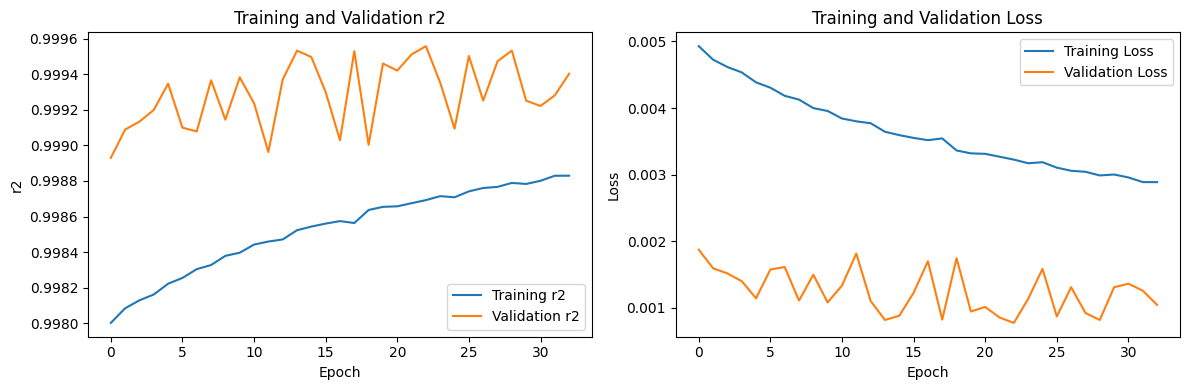

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_final.history['r2'], label='Training r2')
plt.plot(history_final.history['val_r2'], label='Validation r2')
plt.title('Training and Validation r2')
plt.xlabel('Epoch')
plt.ylabel('r2')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Backtesting

### Total

In [ ]:
start_time = time.time()

y_pred_log_best = best_model.predict(X_test_2023_scaled).flatten()

end_time = time.time()
print(f"Backtesting time: {end_time - start_time} seconds")

1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Backtesting time: 2.582449436187744 seconds


In [ ]:
# Destransformar predicciones
y_pred_best = np.expm1(y_pred_log_best)

In [ ]:
print("MAE:", mean_absolute_error(y_test_2023, y_pred_best))
print("RMSE:", mean_squared_error(y_test_2023, y_pred_best))
print("R²:", r2_score(y_test_2023, y_pred_best))

MAE: 0.6934752767165157
RMSE: 4.416910255847661
R²: 0.9876687983123809


### Por Q

In [ ]:
#Dar formato fecha
df_spy_2023['quote_date'] = pd.to_datetime(df_spy_2023['quote_date'])

In [ ]:
quarters = [(1, 3), (4, 6), (7, 9), (10, 12)]
q = 1
for quarter in quarters:
    start_month, end_month = quarter
    conditions = (
        (df_spy_2023['quote_date'].dt.year == 2023) &
        ((df_spy_2023['quote_date'].dt.month >= start_month) & (df_spy_2023['quote_date'].dt.month <= end_month))
    )
    # Features
    df_spy_2023_q = df_spy_2023[conditions]
    X_test_2023_q = df_spy_2023_q[features_cols]
    X_test_2023_q_scaled = scaler.transform(X_test_2023_q)

    # Target
    y_test_2023_q = df_spy_2023_q[target_test]

    # Predecir
    y_pred_log_best_q = best_model.predict(X_test_2023_q_scaled)

    # Destransformar predicciones
    y_pred_best_q = np.expm1(y_pred_log_best_q)

    print(f"***** Backtesting Q{q} *****")
    print("MAE:", mean_absolute_error(y_test_2023_q, y_pred_best_q))
    print("RMSE:", mean_squared_error(y_test_2023_q, y_pred_best_q))
    print("R²:", r2_score(y_test_2023_q, y_pred_best_q))
    print()
    q += 1

354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
***** Backtesting Q1 *****
MAE: 0.6839437662741652
RMSE: 4.3243631839130074
R²: 0.9774673016963213

314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
***** Backtesting Q2 *****
MAE: 0.5836830775379152
RMSE: 2.5151616396228462
R²: 0.9914183265955058

367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
***** Backtesting Q3 *****
MAE: 1.2279512764127352
RMSE: 9.4350857656005
R²: 0.9842434466817535

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
***** Backtesting Q4 *****
MAE: 0.752304213867647
RMSE: 7.271721299609942
R²: 0.9748422559860934



### Por Mes

In [ ]:
m = 1
for month in range(1, 13):
    conditions = (
        (df_spy_2023['quote_date'].dt.year == 2023) &
        (df_spy_2023['quote_date'].dt.month == month)
    )
    # Features
    df_spy_2023_m = df_spy_2023[conditions]
    X_test_2023_m = df_spy_2023_m[features_cols]
    X_test_2023_m_scaled = scaler.transform(X_test_2023_m)

    # Target
    y_test_2023_m = df_spy_2023_m[target_test]

    # Predecir
    y_pred_log_best_m = best_model.predict(X_test_2023_m_scaled)

    # Destransformar predicciones
    y_pred_best_m = np.expm1(y_pred_log_best_m)

    print(f"***** Backtesting Mes {m} *****")
    print("MAE:", mean_absolute_error(y_test_2023_m, y_pred_best_m))
    print("RMSE:", mean_squared_error(y_test_2023_m, y_pred_best_m))
    print("R²:", r2_score(y_test_2023_m, y_pred_best_m))
    print()
    m += 1

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
***** Backtesting Mes 1 *****
MAE: 0.5498119858767078
RMSE: 2.1315048850226526
R²: 0.9878358138929575

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
***** Backtesting Mes 2 *****
MAE: 0.8074114549163415
RMSE: 6.029679026060046
R²: 0.9717814472171549

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
***** Backtesting Mes 3 *****
MAE: 0.7038228147870706
RMSE: 4.912203612870494
R²: 0.9738311085436292

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
***** Backtesting Mes 4 *****
MAE: 0.5788112908016064
RMSE: 2.5094504635571018
R²: 0.9892578249068088

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
***** Backtesting Mes 5 *****
MAE: 0.6117112167573993
RMSE: 3.1315987377953016
R²: 0.9890920987435919

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
***** Backtesting Mes 6 *****
MAE: 0.5576391366566045
RMSE: 1.8646404708175985
R²: 0.9945528490475863

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
***** Backtesting Mes 7 *****
MAE: 1.3534475612728218
RMSE: 9.951041146574862
R²: 0.982053360748910

## Graficas

In [ ]:
pip install scikeras

In [ ]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin

# Custom wrapper for the already trained Keras model
class KerasTrainedModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        # Store the trained Keras model
        self.model = model

    def predict(self, X):
        # Keras predict often returns a 2D array, flatten for compatibility with sklearn metrics
        # Also need to inverse transform the predictions (expm1) as the model predicts on log-transformed target
        log_predictions = self.model.predict(X).flatten()
        return np.expm1(log_predictions)

    def score(self, X, y_true):
        # Calculate R2 score using the inverse-transformed predictions
        y_pred = self.predict(X)
        return r2_score(y_true, y_pred)

    # The fit method is required by BaseEstimator, but for an already trained model, it can be a no-op
    def fit(self, X, y=None):
        return self

    # This property makes the wrapper recognizable as a regressor by scikit-learn utilities
    @property
    def _estimator_type(self):
        return "regressor"

    # Removed __sklearn_tags__ to avoid conflict with _estimator_type in some sklearn versions.
    # The _estimator_type property is sufficient for identifying as a regressor.

# Instantiate the wrapper with your trained Keras model
model_wrapped = KerasTrainedModelWrapper(best_model)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model_wrapped,
    X_test_2023_scaled, # Use the scaled test data for 2023
    y_test_2023,        # Use the actual test target for 2023
    n_repeats=10,
    random_state=42,
    scoring="r2"       # Use R² as the scoring metric
)

importance_mean = result.importances_mean
importance_std  = result.importances_std

df_importance = pd.DataFrame({
    "feature": features_cols,
    "importance": importance_mean,
    "std": importance_std
}).sort_values("importance", ascending=False)

1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1346/1346 ━

In [ ]:
df_importance

,feature,importance,std
6,c_delta,9665.621916,10375.071823
8,c_vega,4524.548217,2477.838899
3,iv_skew,303.262334,119.224915
2,c_iv,277.811613,18.879914
7,c_gamma,0.212881,0.002951
0,moneyness,0.159160,0.016196
1,dte_year,0.015472,0.000463
4,iv_pct_rank,0.010838,0.000258
5,c_volume_log_scaled,0.003728,0.000181
9,c_theta,0.002041,0.000165


In [ ]:
importances = pd.Series(df_importance.importance.values, index=df_importance.feature)
importances.sort_values(ascending=False)

,0
feature,
c_delta,9665.621916
c_vega,4524.548217
iv_skew,303.262334
c_iv,277.811613
c_gamma,0.212881
moneyness,0.159160
dte_year,0.015472
iv_pct_rank,0.010838
c_volume_log_scaled,0.003728


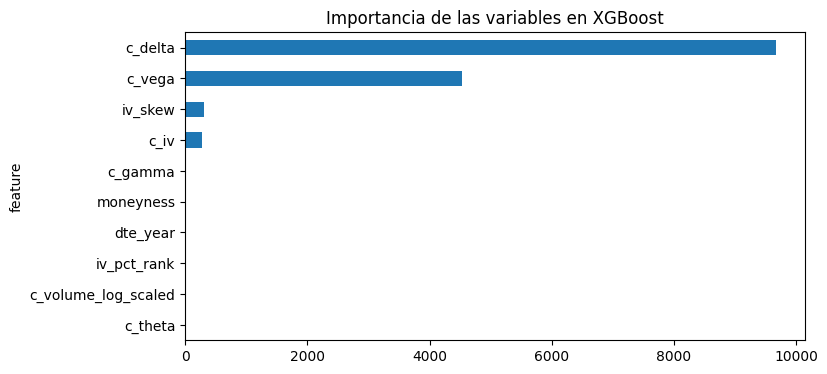

In [ ]:
import matplotlib.pyplot as plt

importances = pd.Series(df_importance.importance.values, index=df_importance.feature)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 4))
plt.title("Importancia de las variables en XGBoost")
plt.show()

## Conclusiones

- R² ≈ 99.26% → el modelo generaliza bien.
- La variable con mayor importancia en el modelo es moneyness.
- Las relaciones en 2023 siguen el comportamiento historico de los 3 ultimos años, el modelo se adapta bien.
- moneyness domina → correcto (S/K controla la convexidad del payoff).
- delta fuerte → correcto (afecta sensibilidad del precio de la opcion respecto al precio del subyacente).
- skew, theta, vega → capturan micro-comportamientos.

**Los resultados del modelo:**
- MAE ≈ 0.62
  - Esto significa que en promedio el modelo se equivoca 62 dólares por contrato (≈ 0.62, sesenta y dos centavos por prima), lo cual es poco eficiente en general.
- RMSE ≈ 2.65
- R² ≈ 0.9926
  - Esto indica que el modelo explica gran parte de la variabilidad del precio.

Sí es razonable para opciones americanas SPY (mucha microestructura, volatilidad, saltos).
- *Incluso los market makers profesionales trabajan con errores absolutos similares cuando no usan el order book directo. SIN EMBARGO, INTERPRETACION:

- **MAE** = 0.6235 -> **En prima:** Error promedio de 62 centavos -> **En contrato  (×100):** Error promedio de $62.35.

- **RMSE** = 2.65 -> **En prima:** Error típico grande de 2.65 dolares -> **En contrato  (x100):** Error promedio de $265 por contrato.

**Conclusion**
- Los resultados de MAE y RMSE son aceptables si el objetivo es determinar el valor Teorico de la opcion (prima).
- El modelo explica gran parte de la variabilidad del precio, pero es ineficiente al momento de determinar el precio real de una opcion.


- Si el **Objetivo es determinar el valor Real de la opcion (prima)** el MAE deberia ser <= 0.10 (10 centavos de dolar en valor de la prima). Ojo esto Difícil pero no imposible llegar a ese MAE, Actualmente no hay modelos que lleguen a ese nivel tan bajo de MAE.

**A nivel académico:***
- Modelos de deep learning de última generación (LSTMs, Transformers, DNN + LSV):
  - MAE ≈ 0.20–0.40 sobre el mid price.
- Sobre last price:
  - MAE ≈ 0.40–1.20

**En bancos y market makers (información no pública pero estandarizada):**
- Para activos muy líquidos (SPY, QQQ):
  - MAE ~ 0.15–0.40 sobre mid
  - MAE ~ 0.30–1.00 sobre last

**Menos líquido:**
- MAE > 1.0 es normal.

**MI HIPOTESIS (PROBARLO):**
- Como pienso aplicar swing-trading (periodos cortos de 3 a 9 dias de trading), podria probar eliminando precios (primas iliquidas), probar entrenar modelo por ITM (menos liquidez) y el mismo modelos pero solo con OTM (mas liquidez).

**Predomina la feature moneyness porque:**

De hecho, de acuerdo al modelo de Black-Scholes:

**Black-Scholes** = f(S,K,T, sigma, r)

- S = Subyacent price
- K = Strike
- T = dte_year
- sigma = c_iv
- r (tasa libre de riesgo) = se puede ignorar para opciones ultracortas.

**Features Optimos del modelo:**
- **moneyness** = S / K
- **dte_year** = T (tiempo de vencimiento en escala de un año)
- **c_iv** = sigma

In [ ]:
# Finished!